# How to Compute the Centroid and Area of a Polygon

A polygon is an areal object: it has an area. But sometimes we tend to think of a polygon as a point. For example, while there are many ways to answer the questions of "where is Columbus?" one way to answer it is to say it is at 83 west and 40 north, which is liberally a point. In games, collisions between game objects can be determined using their center. People might also be interested in where is the geographic center of the conterminous U.S. Here, we call the center of a polygon its **centroid**.

The purpose of this tutorial is to explain the way to estimate polygon centers. As we will see here, when we compute the center of a polygon, we also compute the area at the same time, not because of convenience (which is the case) but also necessity. 

This tutorial will be run on-the-fly in Google Colab. Because of that, it is necessary to load our geometry Python modules (such as point.py). The following line of code clones exactly the entire repository into the running environment of his notebook. Please note this is only needed to run in colab. To run the code in the tutorial in our own local computer using a Python interactive mode, we will use what we did before (i.e., downloading the necessary .py files from the github repo, and putting them in the right folder). There is no need to run this in local Python environment. This line should not be included in a Python program either.

In [1]:
!git clone https://github.com/gisalgs/geom.git 

fatal: destination path 'geom' already exists and is not an empty directory.


The above line may show an error that the path exists already. This happens when it is run multiple times. No need to alert. If the code in this tutorial is run in a local Python interactive mode, we can use the following before we import:

```python
import sys
sys.path.append('/home/xiao/lib/gisalgs')
```

Once the github repo is cloned, it is also loaded and ready to use.

In [2]:
from geom.point import *

We also load necessary matplotlib module for some drawing down the road:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Rationale

We first take a look at a hypothetical polygon and plot its center that is calculated using the average X and Y coordinates. If we calculate the mean X and Y coordinates, they should be 4.0 and 2.8, respectively. This would mean we will see the red point being in a "wrong" place -- it is outside of the polygon. There clearly is a problem of making the center using the average of the coordinates, as the values of the X and Y coordinates control where the point is. In our case above, the two points at the bottom pull the mean point down and outside the shape. If we add more points to the line at the bottom, the mean points will be pulled further down, which the shape remains the same. We would prefer a more reasonable way so that the coordinates do not have so expressive control over where the center should be. Instead, we want our center to be close toward the gravity or mass center of the shape. A point at (3, 3) would be more preferred. This is what the following plot shows.

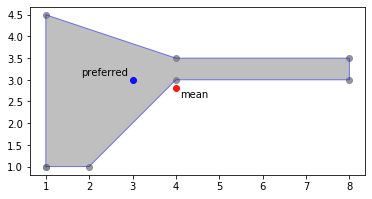

In [4]:
points = [ [1,1], [2,1], [4,3], [8,3], [8,3.5], [4,3.5], [1,4.5], [1,1] ]

polygon = [ Point(p[0], p[1]) for p in points ]


d = Point(4.0, 2.8)

_, ax = plt.subplots()

line1 = [ [p.x, p.y] for p in polygon ]
l1 = plt.Polygon(line1, closed=True, fill=True, facecolor='grey', edgecolor='blue', alpha=0.5)
ax.add_patch(l1)

ax.scatter([p.x for p in polygon], [p.y for p in polygon], color='grey', marker='o', alpha=0.8)

ax.plot(d.x, d.y, marker='o', color='red', alpha=.9)
ax.text(d.x+0.1, d.y-0.2, 'mean')

preferred = Point(3, 3)

ax.plot(preferred.x, preferred.y, color='blue', marker='o', alpha=.9)
plt.text(preferred.x-0.1, preferred.y+0.1, 'preferred', ha='right')

ax.set_aspect(1)

plt.show()

## How to compute gravity center of a shape?

We want our centroid to be within the polygon and close to where the majority of the mass is. This is what we refer to as a **gravity center**. We assume the mass is evenly distributed. If we cut the polygons in parts and the large parts will have a big draw of the center (pulling the center close to them). 

We will start by looking at an example where the polygon shape is [convex](https://en.wikipedia.org/wiki/Convex_polygon).

In [5]:
convex = [ [5,1], [8,2], [10,6], [6,10], [2,9], [0,6], [1,2], [5,1] ]
convex = [Point(p[0], p[1]) for p in convex]

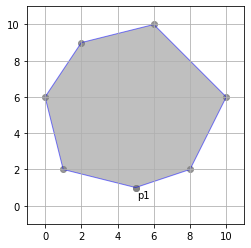

In [6]:
polygon = convex

_, ax = plt.subplots()

line1 = [ [p.x, p.y] for p in polygon ]
l1 = plt.Polygon(line1, closed=True, fill=True, facecolor='grey', edgecolor='blue', alpha=0.5)
ax.add_patch(l1)

ax.scatter([p.x for p in polygon], [p.y for p in polygon], color='grey', marker='o', alpha=0.8)

plt.text(polygon[0].x+0.1, polygon[0].y-0.6, 'p1')

ax.set_aspect(1)

ax.set_ylim([-1, 11])
ax.set_xlim([-1, 11])

ax.grid()
plt.show()

Now we will partition the polygon into a number of parts. To do so, we make sure the parts completely cover the original polygon and the parts do not overlap with each other. Note while the coverage and overlap requirements are not really necessary, they make things simple. More practically, it is doable. Later we will look at another strategy that does not have these requirements.

One way to get the parts is what we call triangulation: we create a sequence of triangles that completely covers the polygon. Here we make sure all the triangle share the same point. Any point will work, but we will use the first point (p1) in the list for convenience. The following code draws the lines of these triangles. If the polygon has $n$ vertices, we will have $n-2$ triangles.

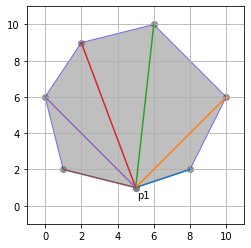

In [7]:
polygon = convex
n = len(polygon)

_, ax = plt.subplots()

line1 = [ [p.x, p.y] for p in polygon ]
l1 = plt.Polygon(line1, closed=True, fill=True, facecolor='grey', edgecolor='blue', alpha=0.5)
ax.add_patch(l1)

ax.scatter([p.x for p in polygon], [p.y for p in polygon], color='grey', marker='o', alpha=0.8)

plt.text(polygon[0].x+0.1, polygon[0].y-0.6, 'p1')

p0 = polygon[0]
for p in polygon[1:-1]:
    ax.plot([p0.x, p.x], [p0.y, p.y])

ax.set_aspect(1)

ax.set_ylim([-1, 11])
ax.set_xlim([-1, 11])

ax.grid()
plt.show()

## Computing triangle area

If we know the three vertices of a triangle as $(x_1, y_1)$, $(x_2, y_2)$, and $(x_3, y_3)$, we can compute the area of the triangle using the [determinant formula](https://people.richland.edu/james/lecture/m116/matrices/area.html):

$
\frac{1}{2} \begin{vmatrix} 
x_1 & y_1 & 1 \\ 
x_2 & y_2 & 1 \\ 
x_3 & y_3 & 1  \notag
\end{vmatrix} ,
$

which can be written as

$
\frac{1}{2} [x_1 (y_2-y_3) - y_1 ( x_2-x_3) + (x_2 y_3 -y_2 x_3)] .
$

This will give us a signed number: it is positive if the three points are in a counter clockwise order, and negative clockwise. Have a singed value is a great feature and we will see how it can be useful later. 

We translate the formula into a function as follows:

In [8]:
def triangle_area(p1, p2, p3):
    a = p1.x * (p2.y-p3.y) - p1.y * ( p2.x-p3.x) + (p2.x*p3.y - p2.y*p3.x)
    a /= 2
    return a

# testing
triangle_area(Point(1, 0), Point(2, 0), Point(0, 3))

1.5

The first triangle in the lower-right of the above figure can be computed below:

In [9]:
p1 = polygon[0]
p2 = polygon[1]
p3 = polygon[2]

area = triangle_area(p1, p2, p3)
area

5.0

We can use a `for` loop to compute the areas of all the triangles, and in the meantime get the total area of the polygon:

In [10]:
polygon = convex
p1 = polygon[0]
area = 0
for i in range(1, len(polygon)-2):
    p2 = polygon[i]
    p3 = polygon[i+1]
    a = triangle_area(p1, p2, p3)
    area += a

print(area)

62.5


## Area-weighted centroid

For a triangle with three vertices $(x_1, y_1)$, $(x_2, y_2)$, and $(x_3, y_3)$, its center can be simply calculated as

$x = \frac{x_1 + x_2 + x_3}{3}$, $y = \frac{y_1 + y_2 + y_3}{3}$

Each of these coordinates is then weighted using the area of the triangle. We can sum all these weighted coordinates for all triangles and then divide the sum by the total area. This will give us the gravity center, or centroid of the polygon.

The following code does the weighting:

In [11]:
polygon = convex
area = 0
xmean = 0
ymean = 0
centers = []

p1 = polygon[0]
for i in range(1, len(polygon)-2):
    p2 = polygon[i]
    p3 = polygon[i+1]
    a = triangle_area(p1, p2, p3) # get triangle area
    x = (p1.x + p2.x + p3.x) / 3  # 
    y = (p1.y + p2.y + p3.y) / 3
    centers.append(Point(x, y))
    xmean += a*x
    ymean += a*y
    
    area += a

xmean /= area
ymean /= area

final_centroid = Point(xmean, ymean)
print(area, final_centroid)

62.5 (4.8, 5.3)


Now we can draw the final centroid along with the centroids of the triangles.

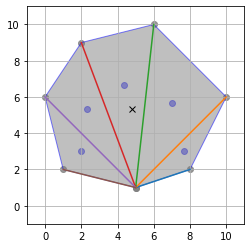

In [12]:
polygon = convex
n = len(polygon)

_, ax = plt.subplots()

line1 = [ [p.x, p.y] for p in polygon ]
l1 = plt.Polygon(line1, closed=True, fill=True, facecolor='grey', edgecolor='blue', alpha=0.5)
ax.add_patch(l1)

p0 = polygon[0]
for p in polygon[1:-1]:
    ax.plot([p0.x, p.x], [p0.y, p.y])

ax.scatter([p.x for p in polygon], [p.y for p in polygon], color='grey', marker='o', alpha=0.8)
ax.scatter([p.x for p in centers], [p.y for p in centers], color='blue', marker='o', alpha=0.5)
ax.plot(final_centroid.x, final_centroid.y, color='k', marker='x', alpha=1)

ax.set_aspect(1)

ax.set_ylim([-1, 11])
ax.set_xlim([-1, 11])

ax.grid()
plt.show()


## Another triangulation

The above approach works fine. But there is a little bit too much computation in calculating the triangle area (multiplications take time). We can rethink the process and this time we look at triangles formed by the two consecutive points on the polygon and the origin. 

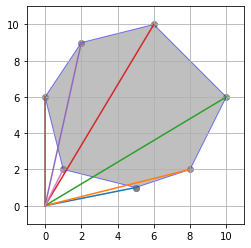

In [13]:
polygon = convex
n = len(polygon)

_, ax = plt.subplots()

line1 = [ [p.x, p.y] for p in polygon ]
l1 = plt.Polygon(line1, closed=True, fill=True, facecolor='grey', edgecolor='blue', alpha=0.5)
ax.add_patch(l1)

ax.scatter([p.x for p in polygon], [p.y for p in polygon], color='grey', marker='o', alpha=0.8)

for p in polygon[:-1]:
    ax.plot([0, p.x], [0, p.y])

ax.set_aspect(1)

ax.set_ylim([-1, 11])
ax.set_xlim([-1, 11])

ax.grid()
plt.show()

Some of the triangles will have a positive area and others negative. More specifically, because the points are counter clockwise ordered, the area formed by lines that are furtherest from the original as positive and then those those closest to the origin as negative. By summing them up, the areas that are not included in the polygon will be canceled out.

In the following figure, draw three sub-plots to show how this works. In the first plot (left), all the triangles have positive areas, and the ones in the middle plot have negative areas. By summing all the areas up, we are able to get the correct area of the polygon (right).

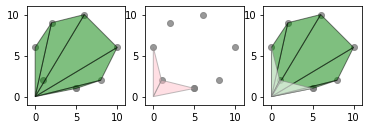

In [14]:
polygon = convex
n = len(polygon)

_, ax = plt.subplots(1, 3) # create 3 plots, ax is a list with three axes

# draw the points on all three
for a in ax:
    a.scatter([p.x for p in polygon], [p.y for p in polygon], color='grey', marker='o', alpha=0.8)

for i in range(5):  # this is fixed for this example
    p1 = polygon[i]
    p2 = polygon[i+1]
    line2 = [ [0,0], [p1.x, p1.y], [p2.x, p2.y]]
    l2 = plt.Polygon(line2, closed=True, fill=True, facecolor='green', edgecolor='black', alpha=0.5)
    ax[0].add_patch(l2)
    l2 = plt.Polygon(line2, closed=True, fill=True, facecolor='green', edgecolor='black', alpha=0.5)
    ax[2].add_patch(l2)

for i in range(5, len(polygon)-1):  # this is fixed for this example
    p1 = polygon[i]
    p2 = polygon[i+1]
    line2 = [ [0,0], [p1.x, p1.y], [p2.x, p2.y]]
    l2 = plt.Polygon(line2, closed=True, fill=True, facecolor='pink', edgecolor='grey', alpha=0.5)
    ax[1].add_patch(l2)
    l2 = plt.Polygon(line2, closed=True, fill=True, facecolor='w', edgecolor='grey', alpha=0.6)
    ax[2].add_patch(l2)

for a in ax:
    a.set_aspect(1)
    a.set_ylim([-1, 11])
    a.set_xlim([-1, 11])

plt.show()

## Triangle areas (a simpler formula)

In the case when the origin is involved, the computation gets a lot simpler: we just need two points to define the triangle. Let's say the two points are $x_1$ and $x_2$. The area can be computed as:

$
\frac{1}{2} \begin{vmatrix} 
x_1 & y_1  \\ 
x_2 & y_2 \notag
\end{vmatrix} ,
$

which can be written as

$
\frac{1}{2} (x_1 y_2 - x_2 y_1) .
$

This will give us a signed number: it is positive if the three points are in a counter clockwise order, and negative clockwise. We translate the formula into a function as follows:

In [15]:
def triangle_area0(p1, p2):
    a = p1.x * p2.y - p2.x * p1.y
    a /= 2
    return a

# testing (this is a half of a unit square)
triangle_area0(Point(1, 0), Point(1, 1))

0.5

We can test one of the triangle with a positive area here:

In [16]:
p1 = polygon[2]
p2 = polygon[3]
triangle_area0(p1, p2)

32.0

Similarly, we can test a triangle with a negative area too:

In [17]:
p1 = polygon[5]
p2 = polygon[6]
triangle_area0(p1, p2)

-3.0


With this spirit, we work on a simpler algorithm:

In [18]:
area = 0
xmean = 0
ymean = 0
centers = []

for i in range(len(polygon)-1):
    p1 = polygon[i]
    p2 = polygon[i+1]
    a = triangle_area0(p1, p2)
    area += a
    x = (p1.x + p2.x) / 3 # the x of the origin is 0
    y = (p1.y + p2.y) / 3 # the y of the origin is 0
    xmean += a * x
    ymean += a * y
    centers.append(Point(x, y))

xmean /= area
ymean /= area
    
final_centroid = Point(xmean, ymean)
print(area, final_centroid)

62.5 (4.8, 5.3)


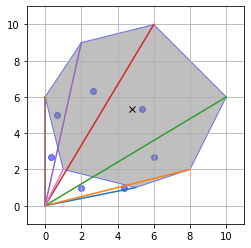

In [19]:
polygon = convex
n = len(polygon)

_, ax = plt.subplots()

line1 = [ [p.x, p.y] for p in polygon ]
l1 = plt.Polygon(line1, closed=True, fill=True, facecolor='grey', edgecolor='blue', alpha=0.5)
ax.add_patch(l1)

ax.scatter([p.x for p in centers], [p.y for p in centers], color='blue', marker='o', alpha=0.5)
ax.plot(final_centroid.x, final_centroid.y, color='k', marker='x', alpha=1)

for p in polygon[:-1]:
    ax.plot([0, p.x], [0, p.y])

ax.set_aspect(1)

ax.set_ylim([-1, 11])
ax.set_xlim([-1, 11])

ax.grid()
plt.show()

So the above code yields exactly the same results we had before. 

## Summary

We can summarize what we did in a more formal way. We suppose there is a polygon of $n$ points and we represent the polygon as a sequence of $n+1$ points: $(x_1, y_1), (x_2, y_2),...,(x_n,y_n),(x_{n+1},y_{n+1})$, where we make sure that the polygon is properly closed $(x_{n+1}, y_{n+1}) = (x_1,y_1)$. The area of the polygon can be calculated as

$A = \frac{1}{2} \mid\sum_{i=1}^n (x_i y_{i+1} - x_{i+1} y_i) \mid .$

The centroid of the polygon is determined as

$x = \frac{1}{6A} \sum_{i=1}^n (x_i + x_{i+1}) (x_i y_{i+1} - x_{i+1}y_i)$

$y = \frac{1}{6A} \sum_{i=1}^n (y_i + y_{i+1}) (x_i y_{i+1} - x_{i+1}y_i)$

where $A$ is the area of the polygon as calculated using the above formulas. 

The above equations are based on the triangles are created: the all share a same point at the origin. 

There are other ways to get the area of a polygon and one more well known method is to use a sequence of trapezoids, which will lead to the following equation for computing the area:

$A = \frac{1}{2} \mid\sum_{i=1}^n (x_i - x_{i+1}) (y_i + y_{i+1}) \mid $

These area commonly used algorithms and we have the code in our github repository at [here](https://github.com/gisalgs/geom/blob/master/centroid.py). It can be downloaded and installed as we did for the other geometry files.